In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q uncertainty-calibration

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass
import calibration as cal
from torch.nn import functional as F
import scipy

from matplotlib import style
import pathlib
from sklearn.linear_model import LogisticRegression
plt.style.use('seaborn-v0_8')

In [ ]:
models = [
    "plip",
    "quilt",
    "biomed",
]

model_map = {
    "plip": "PLIP",
    "biomed": "BioMedCLIP",
    "quilt": "QuiltNet",
    "ens": "Ensemble"
}

datasets = [
    "databiox",
    "sicap",
    "skin",
    "renal_cell",
    "bach",
    "nck",
    "skin_tumor",
    "pcam",
    "mhist",
    "osteo",
    "lc25000_colon",
    "lc25000_lung",
]

dataset_map = {
    "sicap": "SICAP",
    "databiox": "Databiox",
    "renal_cell": "RenalCell",
    "bach": "BACH",
    "osteo": "Osteo",
    "nck": "NCK-CRC",
    "skin_tumor": "Skin Tumor",
    "skin": "Skin Cancer",
    "pcam": "PCam",
    "lc25000_lung": "LC-Lung",
    "lc25000_colon": "LC-Colon",
    "mhist": "MHIST"
}


In [ ]:
def get_ece_em(probs, labels, p=1, debias=False, num_bins=15, mode='top-label'):
    """Get ECE, but use equal mass binning."""
    return cal.lower_bound_scaling_ce(probs, labels, p=p, debias=debias, num_bins=num_bins,
                                  binning_scheme=cal.get_equal_bins, mode=mode)



def get_metrics(model, dataset, descriptors, temp=1.0):

    save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/output/{}/{}/".format(model, dataset)
    if descriptors is not None:
        save_path += descriptors + "_desc_"

    all_features = np.load(save_path+"features.npy")
    all_logits = np.load(save_path+"logits.npy")
    all_labels = np.load(save_path+"labels.npy")

    all_probs = scipy.special.softmax(all_logits/temp, axis=-1)
    all_correctness = (np.argmax(all_logits, -1) == all_labels)*1

    acc = np.sum(all_correctness)/all_labels.shape[0]

    # # calculcate calibration metrics
    ece1 = get_ece_em(np.max(all_probs, -1), all_correctness, p=1)
    ece2 = get_ece_em(np.max(all_probs, -1), all_correctness, p=2)

    print(model, dataset, "| n data:", all_logits.shape[0], "| acc:", acc, "| ece1:", ece1, "| ece2:", ece2)

    return acc, ece1, ece2

In [ ]:
def run_exp(descriptors=None, temp=1.0):

    results = dict()

    for dataset in tqdm(datasets):

        results[dataset] = dict()

        for model in models:

            save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/output/{}/{}/".format(model, dataset)
            if descriptors is not None:
                save_path += descriptors + "_desc_"

            features = np.load(save_path+"features.npy")
            logits = np.load(save_path+"logits.npy")
            labels = np.load(save_path+"labels.npy")

            if dataset == "nck":
                features = features[:20000]
                logits = logits[:20000]
                labels = labels[:20000]

            probs = scipy.special.softmax(logits/temp, axis=-1)
            correctness = (np.argmax(logits, -1) == labels)*1

            results[dataset][model] = {
                "probs": probs,
                "labels": labels,
                "correct": correctness
            }

    total_res = {"ens":[]}

    rows = []
    if descriptors is not None:
        desc_key = descriptors
    else:
        desc_key = "Baseline"

    for dataset in datasets:

        ens_probs = []
        ens_labels = None

        for model in models:

            if model not in total_res:
                total_res[model] = []

            probs = results[dataset][model]["probs"]
            correct = results[dataset][model]["correct"]

            acc = np.sum(correct)/correct.shape[0]

            # # calculcate calibration metrics
            ece1 = get_ece_em(np.max(probs, -1), correct, p=1)
            ece2 = get_ece_em(np.max(probs, -1), correct, p=2)

            ens_probs.append(probs)
            ens_labels = results[dataset][model]["labels"]

            total_res[model].append((acc, ece1, ece2))

            rows.append((model, dataset, desc_key, temp, acc, ece1, ece2))

        ens_probs = np.array(ens_probs)
        ens_probs = np.mean(ens_probs, 0)
        ens_correct = (np.argmax(ens_probs, -1) == ens_labels)*1
        acc = np.sum(ens_correct)/ens_correct.shape[0]

        # # calculcate calibration metrics
        ece1 = get_ece_em(np.max(ens_probs, -1), ens_correct, p=1)
        ece2 = get_ece_em(np.max(ens_probs, -1), ens_correct, p=2)

        total_res["ens"].append((acc, ece1, ece2))
        rows.append(("ens", dataset, desc_key, temp, acc, ece1, ece2))


    df = pd.DataFrame(rows, columns=["model", "dataset", "descriptors", "temp", "acc", "ece1", "ece2"])
    return df




def mega_ensemble(temp=1.0):

    rows = []

    for dataset in tqdm(datasets):

        ens_probs = []
        ens_labels = None


        for model in models:

            for descriptors in [None, "sentence", "feature"]:

                save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/output/{}/{}/".format(model, dataset)
                if descriptors is not None:
                    save_path += descriptors + "_desc_"

                features = np.load(save_path+"features.npy")
                logits = np.load(save_path+"logits.npy")
                labels = np.load(save_path+"labels.npy")

                if dataset == "nck":
                    features = features[:20000]
                    logits = logits[:20000]
                    labels = labels[:20000]

                probs = scipy.special.softmax(logits/temp, axis=-1)
                # print(dataset, model, descriptors, probs.shape)
                correctness = (np.argmax(logits, -1) == labels)*1

                ens_probs.append(probs)
                ens_labels = labels

        ens_probs = np.array(ens_probs)
        ens_probs = np.mean(ens_probs, 0)
        ens_correct = (np.argmax(ens_probs, -1) == ens_labels)*1
        acc = np.sum(ens_correct)/ens_correct.shape[0]

        # # calculcate calibration metrics
        ece1 = get_ece_em(np.max(ens_probs, -1), ens_correct, p=1)
        ece2 = get_ece_em(np.max(ens_probs, -1), ens_correct, p=2)

        row = ("ens", dataset, "all", temp, acc, ece1, ece2)
        rows.append(row)


    df = pd.DataFrame(rows, columns=["model", "dataset", "descriptors", "temp", "acc", "ece1", "ece2"])
    return df



def prompt_ensemble(temp=1.0):

    rows = []

    for dataset in tqdm(datasets):




        for model in models:

            ens_probs = []
            ens_labels = None

            for descriptors in [None, "sentence", "feature"]:

                save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/output/{}/{}/".format(model, dataset)
                if descriptors is not None:
                    save_path += descriptors + "_desc_"

                features = np.load(save_path+"features.npy")
                logits = np.load(save_path+"logits.npy")
                labels = np.load(save_path+"labels.npy")

                if dataset == "nck":
                    features = features[:20000]
                    logits = logits[:20000]
                    labels = labels[:20000]

                probs = scipy.special.softmax(logits/temp, axis=-1)
                # print(dataset, model, descriptors, probs.shape)
                correctness = (np.argmax(logits, -1) == labels)*1

                ens_probs.append(probs)
                ens_labels = labels

            ens_probs = np.array(ens_probs)
            ens_probs = np.mean(ens_probs, 0)
            ens_correct = (np.argmax(ens_probs, -1) == ens_labels)*1
            acc = np.sum(ens_correct)/ens_correct.shape[0]

            # # calculcate calibration metrics
            ece1 = get_ece_em(np.max(ens_probs, -1), ens_correct, p=1)
            ece2 = get_ece_em(np.max(ens_probs, -1), ens_correct, p=2)

            row = (model, dataset, "all", temp, acc, ece1, ece2)
            rows.append(row)


    df = pd.DataFrame(rows, columns=["model", "dataset", "descriptors", "temp", "acc", "ece1", "ece2"])
    return df



In [ ]:
full_df = pd.DataFrame()
full_df = pd.concat([full_df, run_exp(descriptors=None)])
full_df = pd.concat([full_df, run_exp(descriptors="feature")])
full_df = pd.concat([full_df, run_exp(descriptors="sentence")])
full_df = pd.concat([full_df, prompt_ensemble()])
full_df = pd.concat([full_df, mega_ensemble()])
full_df

100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


,model,dataset,descriptors,temp,acc,ece1,ece2
0,plip,databiox,Baseline,1.0,0.379587,0.152004,0.161718
1,quilt,databiox,Baseline,1.0,0.404817,0.078360,0.094676
2,biomed,databiox,Baseline,1.0,0.340596,0.601630,0.616200
3,ens,databiox,Baseline,1.0,0.338303,0.196864,0.206039
4,plip,sicap,Baseline,1.0,0.445335,0.118225,0.128951
...,...,...,...,...,...,...,...
7,ens,pcam,all,1.0,0.685547,0.063300,0.080433
8,ens,mhist,all,1.0,0.580901,0.056266,0.067752
9,ens,osteo,all,1.0,0.487626,0.100426,0.114443
10,ens,lc25000_colon,all,1.0,0.822582,0.040628,0.046364


In [ ]:
final_df = full_df[["model", "descriptors", "acc", "ece1", "ece2"]].groupby(["model", "descriptors"]).agg([np.mean, np.max])
final_df

acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed Baseline     0.476444  0.853285  0.337730  0.601630  0.357003  0.616200
       all          0.511543  0.835284  0.250338  0.530210  0.273950  0.552455
       feature      0.514272  0.830083  0.319241  0.583291  0.344507  0.597882
       sentence     0.503381  0.812881  0.339331  0.552930  0.362737  0.577604
ens    Baseline     0.557297  0.857986  0.108354  0.196864  0.121507  0.206039
       all          0.576625  0.830200  0.092594  0.169687  0.103476  0.176493
       feature      0.558581  0.806781  0.098818  0.309581  0.113166  0.319941
       sentence     0.557660  0.793679  0.095591  0.225967  0.112326  0.288591
plip   Baseline     0.534518  0.787667  0.126512  0.171090  0.140865  0.192373
       all          0.544826  0.794533  0.118210  0.206091  0.134479  0.225517
       feature      0.522949  0.818733  0.162492  0.239847  0.179958  0.267215
       sentence     0.518485  0.737200  0.200575  0.370909  0.229662  0.459162
quilt  Baseline     0.547466  0.932793  0.129532  0.294919  0.143568  0.312211
       all          0.566781  0.876933  0.133820  0.292546  0.148679  0.318419
       feature      0.537439  0.789779  0.132605  0.309077  0.146091  0.343882
       sentence     0.532289  0.864800  0.146649  0.398147  0.165300  0.429356

In [ ]:
mean_df = full_df[["model", "descriptors", "acc", "ece1", "ece2"]].groupby(["model", "descriptors"]).mean()
mean_df

acc      ece1      ece2
model  descriptors                              
biomed Baseline     0.476444  0.337730  0.357003
       all          0.511543  0.250338  0.273950
       feature      0.514272  0.319241  0.344507
       sentence     0.503381  0.339331  0.362737
ens    Baseline     0.557297  0.108354  0.121507
       all          0.576625  0.092594  0.103476
       feature      0.558581  0.098818  0.113166
       sentence     0.557660  0.095591  0.112326
plip   Baseline     0.534518  0.126512  0.140865
       all          0.544826  0.118210  0.134479
       feature      0.522949  0.162492  0.179958
       sentence     0.518485  0.200575  0.229662
quilt  Baseline     0.547466  0.129532  0.143568
       all          0.566781  0.133820  0.148679
       feature      0.537439  0.132605  0.146091
       sentence     0.532289  0.146649  0.165300

In [ ]:
max_df = full_df[["model", "descriptors", "ece1", "ece2"]].groupby(["model", "descriptors"]).max()
max_df

ece1      ece2
model  descriptors                    
biomed Baseline     0.601630  0.616200
       all          0.530210  0.552455
       feature      0.583291  0.597882
       sentence     0.552930  0.577604
ens    Baseline     0.196864  0.206039
       all          0.169687  0.176493
       feature      0.309581  0.319941
       sentence     0.225967  0.288591
plip   Baseline     0.171090  0.192373
       all          0.206091  0.225517
       feature      0.239847  0.267215
       sentence     0.370909  0.459162
quilt  Baseline     0.294919  0.312211
       all          0.292546  0.318419
       feature      0.309077  0.343882
       sentence     0.398147  0.429356

In [ ]:
function_dictionary = {'ece1':['mean', 'max'],'ece2':['mean', 'max'],'acc':'mean'}
big_df = full_df[["model", "descriptors", "acc", "ece1", "ece2"]].groupby(["model", "descriptors"]).aggregate(function_dictionary)

In [ ]:
fullest_df = pd.DataFrame()
temps = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
for temp in temps:

    df = mega_ensemble(temp=temp)
    final_df = df[["model", "descriptors", "acc", "ece1", "ece2"]].groupby(["model", "descriptors"]).agg([np.mean, np.max])
    print("-----------------")
    print("Temp:", temp)
    display(final_df)
    print("-----------------")

    fullest_df = pd.concat([fullest_df, df])

    df = prompt_ensemble(temp=temp)
    final_df = df[["model", "descriptors", "acc", "ece1", "ece2"]].groupby(["model", "descriptors"]).agg([np.mean, np.max])
    print("-----------------")
    display(final_df)
    print("-----------------")
    print("-----------------")

    fullest_df = pd.concat([fullest_df, df])


100%|██████████| 12/12 [00:17<00:00,  1.49s/it]

-----------------
Temp: 0.5


acc                ece1                ece2          
                       mean       max      mean       max      mean       max
model descriptors                                                            
ens   all          0.582602  0.844867  0.086424  0.209741  0.098018  0.225925

-----------------


100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

-----------------


acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed all          0.513241  0.835084  0.295921  0.555889  0.322701  0.583866
plip   all          0.540927  0.794667  0.195114  0.306778  0.217946  0.341555
quilt  all          0.565909  0.874733  0.150274  0.384513  0.168409  0.418285

-----------------
-----------------


100%|██████████| 12/12 [00:09<00:00,  1.20it/s]

-----------------
Temp: 0.6


acc                ece1                ece2          
                       mean       max      mean       max      mean       max
model descriptors                                                            
ens   all          0.581168  0.840333  0.082847  0.204947  0.094539  0.215219

-----------------


100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

-----------------


acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed all          0.512797  0.835284  0.287878  0.551270  0.313258  0.578472
plip   all          0.541802  0.794467  0.174440  0.285100  0.195613  0.312962
quilt  all          0.566491  0.875467  0.135764  0.360005  0.152359  0.393640

-----------------
-----------------


100%|██████████| 12/12 [00:10<00:00,  1.19it/s]

-----------------
Temp: 0.7


acc                ece1               ece2          
                       mean       max      mean      max      mean       max
model descriptors                                                           
ens   all          0.579913  0.836733  0.083662  0.19259  0.095372  0.204399

-----------------


100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

-----------------


acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed all          0.512757  0.835184  0.277380  0.544855  0.302487  0.571757
plip   all          0.543163  0.795000  0.156719  0.263109  0.176044  0.288175
quilt  all          0.566409  0.876333  0.129278  0.342215  0.143201  0.370568

-----------------
-----------------


100%|██████████| 12/12 [00:09<00:00,  1.22it/s]

-----------------
Temp: 0.8


acc                ece1              ece2          
                       mean       max      mean      max     mean       max
model descriptors                                                          
ens   all          0.579022  0.833933  0.085267  0.18453  0.09783  0.193993

-----------------


100%|██████████| 12/12 [00:10<00:00,  1.12it/s]

-----------------


acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed all          0.512546  0.835184  0.268041  0.540115  0.292291  0.565233
plip   all          0.543803  0.794867  0.141327  0.242074  0.159367  0.265727
quilt  all          0.566715  0.876333  0.128035  0.325459  0.141046  0.352656

-----------------
-----------------


100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

-----------------
Temp: 0.9


acc                ece1                ece2          
                       mean       max      mean       max      mean       max
model descriptors                                                            
ens   all          0.578059  0.832067  0.087985  0.174711  0.099747  0.183464

-----------------


100%|██████████| 12/12 [00:11<00:00,  1.05it/s]

-----------------


acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed all          0.512213  0.834983  0.258774  0.535989  0.283187  0.560562
plip   all          0.544233  0.794800  0.129591  0.223117  0.146132  0.243138
quilt  all          0.566808  0.876800  0.129826  0.307736  0.143885  0.333999

-----------------
-----------------


100%|██████████| 12/12 [00:10<00:00,  1.18it/s]

-----------------
Temp: 1.0


acc              ece1                ece2          
                       mean     max      mean       max      mean       max
model descriptors                                                          
ens   all          0.576625  0.8302  0.092594  0.169687  0.103476  0.176493

-----------------


100%|██████████| 12/12 [00:10<00:00,  1.11it/s]

-----------------


acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed all          0.511543  0.835284  0.250338  0.530210  0.273950  0.552455
plip   all          0.544826  0.794533  0.118210  0.206091  0.134479  0.225517
quilt  all          0.566781  0.876933  0.133820  0.292546  0.148679  0.318419

-----------------
-----------------


100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

-----------------
Temp: 1.1


acc              ece1                ece2        
                       mean     max      mean       max      mean     max
model descriptors                                                        
ens   all          0.575575  0.8286  0.097775  0.159033  0.109346  0.1702

-----------------


100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

-----------------


acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed all          0.511253  0.835084  0.239353  0.521690  0.262744  0.543560
plip   all          0.544982  0.794200  0.110341  0.192659  0.126663  0.210876
quilt  all          0.567047  0.877133  0.138483  0.299742  0.153742  0.305076

-----------------
-----------------


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

-----------------
Temp: 1.2


acc                ece1                ece2          
                       mean       max      mean       max      mean       max
model descriptors                                                            
ens   all          0.574618  0.827333  0.100482  0.161795  0.111701  0.170593

-----------------


100%|██████████| 12/12 [00:11<00:00,  1.03it/s]

-----------------


acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed all          0.511021  0.834883  0.229299  0.513914  0.252168  0.535626
plip   all          0.545148  0.794333  0.104115  0.177127  0.120826  0.198711
quilt  all          0.566902  0.877067  0.143809  0.315505  0.158492  0.320873

-----------------
-----------------


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]

-----------------
Temp: 1.3


acc                ece1              ece2          
                       mean       max      mean     max      mean       max
model descriptors                                                          
ens   all          0.573848  0.826333  0.104186  0.1788  0.115253  0.187994

-----------------


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]

-----------------


acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed all          0.510983  0.834883  0.219359  0.504678  0.242319  0.527400
plip   all          0.545623  0.794067  0.099248  0.164809  0.116246  0.182996
quilt  all          0.566933  0.877000  0.149588  0.329595  0.163951  0.335117

-----------------
-----------------


100%|██████████| 12/12 [00:11<00:00,  1.00it/s]

-----------------
Temp: 1.4


acc             ece1                ece2          
                       mean    max      mean       max      mean       max
model descriptors                                                         
ens   all          0.572898  0.825  0.106815  0.195074  0.118156  0.203923

-----------------


100%|██████████| 12/12 [00:11<00:00,  1.04it/s]

-----------------


acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed all          0.510865  0.834983  0.209781  0.496354  0.232630  0.518281
plip   all          0.545546  0.794200  0.095332  0.153707  0.111452  0.172723
quilt  all          0.567176  0.877133  0.155821  0.342431  0.170370  0.348095

-----------------
-----------------


100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

-----------------
Temp: 1.5


acc             ece1                ece2          
                       mean     max     mean       max      mean       max
model descriptors                                                         
ens   all          0.571919  0.8238  0.10938  0.209601  0.120584  0.218417

-----------------


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]

-----------------


acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed all          0.511041  0.835184  0.200350  0.486730  0.222765  0.509151
plip   all          0.545639  0.794200  0.093312  0.138168  0.109619  0.161150
quilt  all          0.567371  0.877267  0.161636  0.354002  0.176880  0.359768

-----------------
-----------------


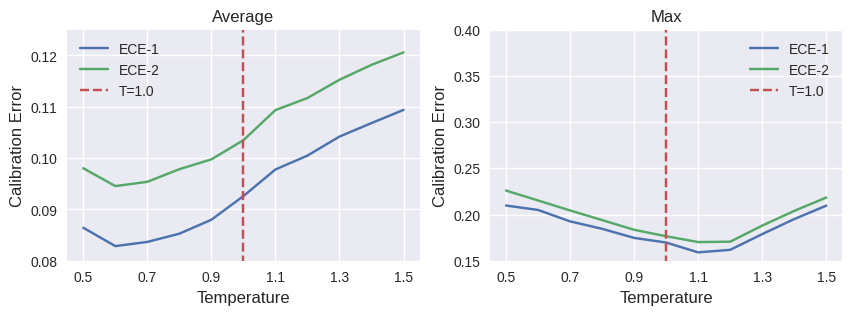

In [ ]:
plt.rcParams["figure.figsize"] = (10,3)
fig, axs = plt.subplots(1,2)



mean_df = fullest_df[["model", "descriptors", "temp", "acc", "ece1", "ece2"]].groupby(["model", "descriptors", "temp"]).mean()

temps = np.arange(0.5, 1.6, 0.1)
ece1 = mean_df["ece1"].tolist()
ece2 = mean_df["ece2"].tolist()
cler = list(1-np.array(mean_df["acc"].tolist()))

axs[0].plot(temps, ece1, label="ECE-1")
axs[0].plot(temps, ece2, label="ECE-2")
axs[0].plot([1.0, 1.0], [0.0, 1.0], "--", label="T=1.0")

axs[0].legend()
axs[0].set_xlabel("Temperature", fontsize=12)
axs[0].set_ylabel("Calibration Error", fontsize=12)
axs[0].set_xticks(np.arange(0.5, 1.6, 0.2))
axs[0].set_ylim(0.08, 0.125)
axs[0].set_title("Average")

max_df = fullest_df[["model", "descriptors", "temp", "acc", "ece1", "ece2"]].groupby(["model", "descriptors", "temp"]).max()

temps = np.arange(0.5, 1.6, 0.1)
ece1 = max_df["ece1"].tolist()
ece2 = max_df["ece2"].tolist()
cler = list(1-np.array(max_df["acc"].tolist()))

axs[1].plot(temps, ece1, label="ECE-1")
axs[1].plot(temps, ece2, label="ECE-2")
axs[1].plot([1.0, 1.0], [0.0, 1.0], "--", label="T=1.0")

axs[1].legend()
axs[1].set_xlabel("Temperature", fontsize=12)
axs[1].set_ylabel("Calibration Error", fontsize=12)
axs[1].set_xticks(np.arange(0.5, 1.6, 0.2))
axs[1].set_ylim(0.15, 0.4)
axs[1].set_title("Max")

plt.show()

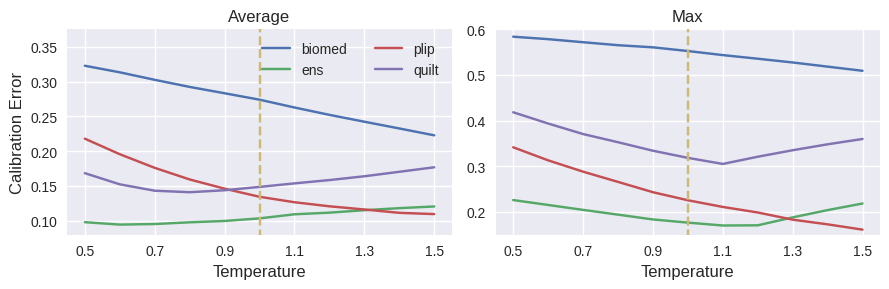

In [ ]:
plt.rcParams["figure.figsize"] = (9,3)
fig, axs = plt.subplots(1,2)

model_list = list(set(fullest_df["model"].tolist()))

for m in model_list:

    sub_df = fullest_df[fullest_df["model"] == m]

    mean_df = sub_df[["model", "descriptors", "temp", "acc", "ece1", "ece2"]].groupby(["model", "descriptors", "temp"]).mean()

    temps = np.arange(0.5, 1.6, 0.1)
    ece1 = mean_df["ece1"].tolist()
    ece2 = mean_df["ece2"].tolist()
    cler = list(1-np.array(mean_df["acc"].tolist()))

    # axs[0].plot(temps, ece1, label="ECE-1")
    axs[0].plot(temps, ece2, label=m)


    max_df = sub_df[["model", "descriptors", "temp", "acc", "ece1", "ece2"]].groupby(["model", "descriptors", "temp"]).max()

    temps = np.arange(0.5, 1.6, 0.1)
    ece1 = max_df["ece1"].tolist()
    ece2 = max_df["ece2"].tolist()
    cler = list(1-np.array(max_df["acc"].tolist()))

    # axs[1].plot(temps, ece1, label="ECE-1")
    axs[1].plot(temps, ece2, label=m)


axs[0].plot([1.0, 1.0], [0.0, 1.0], "--")#, label="T=1.0")
axs[1].plot([1.0, 1.0], [0.0, 1.0], "--")#, label="T=1.0")

axs[0].legend(ncol=2)
axs[0].set_xlabel("Temperature", fontsize=12)
axs[0].set_ylabel("Calibration Error", fontsize=12)
axs[0].set_xticks(np.arange(0.5, 1.6, 0.2))
axs[0].set_ylim(0.08, 0.375)
axs[0].set_title("Average")


# axs[1].legend(ncol=2)
axs[1].set_xlabel("Temperature", fontsize=12)
# axs[1].set_ylabel("Calibration Error", fontsize=12)
axs[1].set_xticks(np.arange(0.5, 1.6, 0.2))
axs[1].set_ylim(0.15, 0.6)
axs[1].set_title("Max")

fig.tight_layout()
plt.show()

In [ ]:
final_df = full_df[["model", "descriptors", "acc", "ece1", "ece2"]].groupby(["model", "descriptors"]).agg([np.mean, np.max])
final_df

acc                ece1                ece2          
                        mean       max      mean       max      mean       max
model  descriptors                                                            
biomed Baseline     0.476444  0.853285  0.337730  0.601630  0.357003  0.616200
       all          0.511543  0.835284  0.250338  0.530210  0.273950  0.552455
       feature      0.514283  0.830083  0.319181  0.583291  0.344364  0.597882
       sentence     0.503549  0.812881  0.339274  0.552930  0.362663  0.577604
ens    Baseline     0.557297  0.857986  0.108354  0.196864  0.121507  0.206039
       all          0.576625  0.830200  0.092594  0.169687  0.103476  0.176493
       feature      0.558861  0.806781  0.099021  0.309581  0.113292  0.319941
       sentence     0.557805  0.793679  0.095600  0.225967  0.112226  0.288591
plip   Baseline     0.534518  0.787667  0.126512  0.171090  0.140865  0.192373
       all          0.544826  0.794533  0.118210  0.206091  0.134479  0.225517
       feature      0.523184  0.818733  0.162474  0.239847  0.179857  0.267215
       sentence     0.518589  0.737200  0.200441  0.370909  0.229405  0.459162
quilt  Baseline     0.547466  0.932793  0.129532  0.294919  0.143568  0.312211
       all          0.566781  0.876933  0.133820  0.292546  0.148679  0.318419
       feature      0.537836  0.789779  0.132943  0.309077  0.146355  0.343882
       sentence     0.532106  0.864800  0.146557  0.398147  0.165137  0.429356

In [ ]:
mean_df = full_df[["model", "descriptors", "acc", "ece1", "ece2"]].groupby(["model", "descriptors"]).mean()
mean_df

acc      ece1      ece2
model  descriptors                              
biomed Baseline     0.476444  0.337730  0.357003
       all          0.511543  0.250338  0.273950
       feature      0.514283  0.319181  0.344364
       sentence     0.503549  0.339274  0.362663
ens    Baseline     0.557297  0.108354  0.121507
       all          0.576625  0.092594  0.103476
       feature      0.558861  0.099021  0.113292
       sentence     0.557805  0.095600  0.112226
plip   Baseline     0.534518  0.126512  0.140865
       all          0.544826  0.118210  0.134479
       feature      0.523184  0.162474  0.179857
       sentence     0.518589  0.200441  0.229405
quilt  Baseline     0.547466  0.129532  0.143568
       all          0.566781  0.133820  0.148679
       feature      0.537836  0.132943  0.146355
       sentence     0.532106  0.146557  0.165137

In [ ]:
# final_df = full_df[["model", "descriptors", "acc", "ece1", "ece2"]].groupby(["model", "descriptors"]).agg([np.mean, np.std])
max_df = full_df[["model", "descriptors", "ece1", "ece2"]].groupby(["model", "descriptors"]).max()
max_df

ece1      ece2
model  descriptors                    
biomed Baseline     0.601630  0.616200
       all          0.530210  0.552455
       feature      0.583291  0.597882
       sentence     0.552930  0.577604
ens    Baseline     0.196864  0.206039
       all          0.169687  0.176493
       feature      0.309581  0.319941
       sentence     0.225967  0.288591
plip   Baseline     0.171090  0.192373
       all          0.206091  0.225517
       feature      0.239847  0.267215
       sentence     0.370909  0.459162
quilt  Baseline     0.294919  0.312211
       all          0.292546  0.318419
       feature      0.309077  0.343882
       sentence     0.398147  0.429356